# Explainable Survival: From Prediction to Trust in Hex

This notebook presents an end-to-end machine learning workflow for
predicting passenger survival on the Titanic.

It covers data preparation, feature engineering, model training,
validation, error analysis, and explainability using SHAP.

The goal is not leaderboard optimization, but building a reproducible,
interpretable, and decision-ready model suitable for interactive
exploration in Hex.

### Phase 1 · Modeling & Validation
(complete — frozen)

In [131]:
# ============================================
# Environment setup (local execution)
# ============================================

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [132]:
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 200)

In [133]:
# Define local data directory
DATA_DIR = "../data/raw"

# Optional: list available files (Kaggle-equivalent sanity check)
print("Files in data directory:")
for filename in os.listdir(DATA_DIR):
    print(os.path.join(DATA_DIR, filename))

# Load datasets (paths adapted from Kaggle)
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print("\nTrain shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Load training data (local path)
train_data = pd.read_csv("../data/raw/train.csv")
train_data.head()

test_data = pd.read_csv("../data/raw/test.csv")
test_data.head()

Files in data directory:
../data/raw\gender_submission.csv
../data/raw\test.csv
../data/raw\train.csv

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [134]:
train_data.shape

train_data.dtypes

unique_value_counts_train = train_data.nunique()
print(unique_value_counts_train)

missing_value_counts_train = train_data.isnull().sum()
print(missing_value_counts_train)

test_data.shape

unique_value_counts_test = test_data.nunique()
print(unique_value_counts_test)

missing_value_counts_test = test_data.isnull().sum()
print(missing_value_counts_test)

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [135]:
# Define a function to perform the data transformations
def transform_data(data):
    
    # Drop 'Name' column
    data.drop(columns=['Name'], inplace=True)
    
    # Convert 'Sex' to 0 for 'male' and 1 for 'female'
    sex_mapping = {'male': 0, 'female': 1}
    data['Sex'] = data['Sex'].map(sex_mapping)

    # Encode Age as a binary "present vs missing" indicator (unchanged logic)
    data['Age'] = data['Age'].fillna(0)
    data['Age'] = data['Age'].apply(lambda x: 1 if x > 0 else x)
    
    # Rename for correct semantics (NO value change)
    data.rename(columns={'Age': 'AgeMissing'}, inplace=True)

    # Create a new feature 'FamSz' by summing 'SibSp' and 'Parch'
    data['FamSz'] = data['SibSp'] + data['Parch']

    # Drop 'Ticket', 'Cabin', 'Fare', 'PassengerId' columns
    data.drop(columns=['Ticket', 'Cabin', 'Fare', 'PassengerId'], inplace=True)

    # Fill missing values in 'Embarked' with mode
    embarked_mode = data['Embarked'].mode()[0]
    data['Embarked'] = data['Embarked'].fillna(embarked_mode)

    # Convert 'Embarked' to numeric values (1, 2, 3)
    embarked_mapping = {'S': 1, 'C': 2, 'Q': 3}
    data['Embarked'] = data['Embarked'].map(embarked_mapping)
    
    return data

In [136]:
# Save PassengerId BEFORE transform_data drops it (for submission output)
test_passenger_ids = test_data["PassengerId"].copy()

# Apply the transformations to both training and testing data
train_data = transform_data(train_data)
test_data = transform_data(test_data)

# Verify the transformations
print(train_data.head())
print(test_data.head())

   Survived  Pclass  Sex  AgeMissing  SibSp  Parch  Embarked  FamSz
0         0       3    0         1.0      1      0         1      1
1         1       1    1         1.0      1      0         2      1
2         1       3    1         1.0      0      0         1      0
3         1       1    1         1.0      1      0         1      1
4         0       3    0         1.0      0      0         1      0
   Pclass  Sex  AgeMissing  SibSp  Parch  Embarked  FamSz
0       3    0         1.0      0      0         3      0
1       3    1         1.0      1      0         1      1
2       2    0         1.0      0      0         3      0
3       3    0         1.0      0      0         1      0
4       3    1         1.0      1      1         1      2


In [137]:
unique_value_counts_train = train_data.nunique()
print(unique_value_counts_train)

missing_value_counts_train = train_data.isnull().sum()
print(missing_value_counts_train)

unique_value_counts_test = test_data.nunique()
print(unique_value_counts_test)

missing_value_counts_test = test_data.isnull().sum()
print(missing_value_counts_test)

train_data.dtypes

Survived      2
Pclass        3
Sex           2
AgeMissing    2
SibSp         7
Parch         7
Embarked      3
FamSz         9
dtype: int64
Survived      0
Pclass        0
Sex           0
AgeMissing    0
SibSp         0
Parch         0
Embarked      0
FamSz         0
dtype: int64
Pclass        3
Sex           2
AgeMissing    2
SibSp         7
Parch         8
Embarked      3
FamSz         9
dtype: int64
Pclass        0
Sex           0
AgeMissing    0
SibSp         0
Parch         0
Embarked      0
FamSz         0
dtype: int64


Survived        int64
Pclass          int64
Sex             int64
AgeMissing    float64
SibSp           int64
Parch           int64
Embarked        int64
FamSz           int64
dtype: object

In [138]:
assert train_data.isna().sum().sum() == 0, "NaNs present in training data"
assert test_data.isna().sum().sum() == 0, "NaNs present in test data"

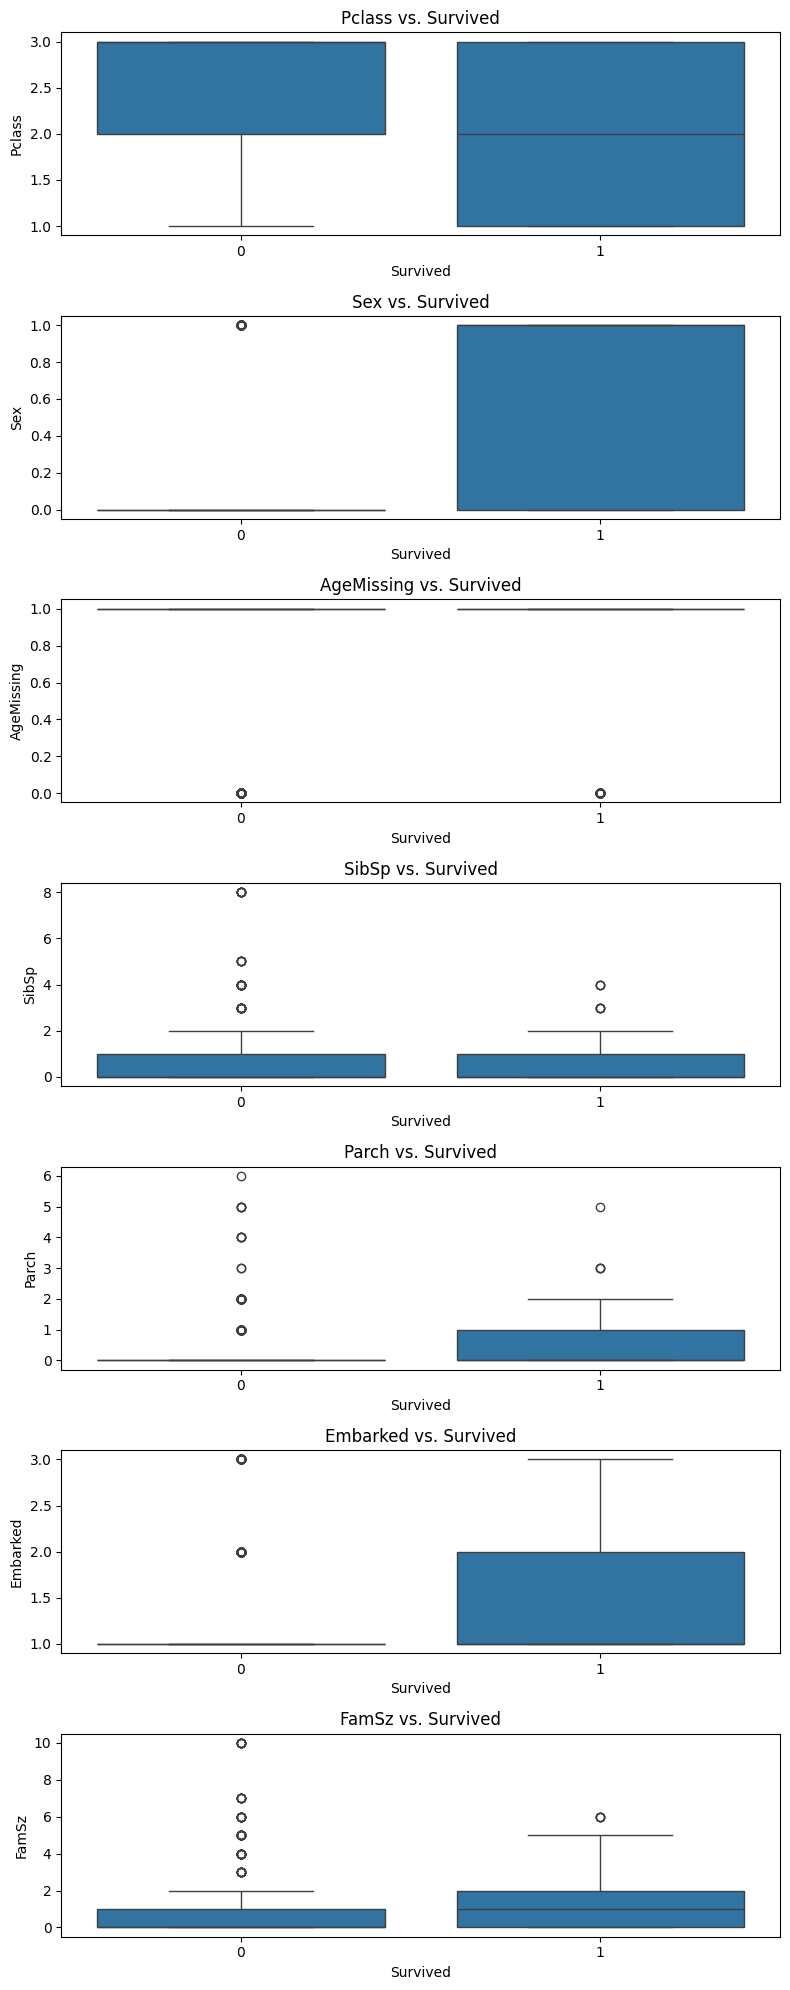

In [139]:
# Define the numeric features you want to plot
numeric_features = ['Pclass', 'Sex', 'AgeMissing', 'SibSp', 'Parch', 'Embarked', 'FamSz']

# Create a figure with subplots for each feature
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=1, figsize=(8, 20))

# Loop through each feature and create a box plot
for i, feature in enumerate(numeric_features):
    sns.boxplot(x='Survived', y=feature, data=train_data, ax=axes[i])
    axes[i].set_title(f'{feature} vs. Survived')

plt.tight_layout()
plt.show()

In [140]:
# Separate the target variable 'Survived' from the training data
X_train = train_data.drop(columns=['Survived']).copy()
y_train = train_data['Survived'].copy()

# Ensure the test dataset has the same features (excluding 'Survived')
X_test = test_data.copy()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (891, 7)
y_train shape: (891,)
X_test shape: (418, 7)


In [141]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the scaler on your training data
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convert the NumPy arrays back to DataFrames
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns)

In [142]:
# Check the summary statistics of the normalized data
print("Summary Statistics for X_train_normalized:")
print(X_train_normalized_df.describe())
print("\nSummary Statistics for X_test_normalized:")
print(X_test_normalized_df.describe())

Summary Statistics for X_train_normalized:
             Pclass           Sex    AgeMissing         SibSp         Parch      Embarked         FamSz
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02
mean  -8.772133e-17  3.987333e-17 -3.638441e-17  4.386066e-17  5.382900e-17  1.056643e-16 -3.987333e-18
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00
min   -1.566107e+00 -7.376951e-01 -2.008457e+00 -4.745452e-01 -4.736736e-01 -5.688371e-01 -5.609748e-01
25%   -3.693648e-01 -7.376951e-01  4.978947e-01 -4.745452e-01 -4.736736e-01 -5.688371e-01 -5.609748e-01
50%    8.273772e-01 -7.376951e-01  4.978947e-01 -4.745452e-01 -4.736736e-01 -5.688371e-01 -5.609748e-01
75%    8.273772e-01  1.355574e+00  4.978947e-01  4.327934e-01 -4.736736e-01  1.005181e+00  5.915988e-02
max    8.273772e-01  1.355574e+00  4.978947e-01  6.784163e+00  6.974147e+00  2.579199e+00  5.640372e+00

Summary Statistics f

In [143]:
# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [2, 4, 8, 10, 25, 50, 100],
    'max_depth': [None, 2, 3, 4, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Create a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

In [144]:
# Fit the grid search to your training data
grid_search.fit(X_train_normalized, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Use the best model for prediction and evaluation
y_test_pred_rf = best_model.predict(X_test_normalized)

output = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": y_test_pred_rf
})

output.to_csv('../submissions/rfc_gs.csv', index=False)

print("Your submission was successfully saved!")

Fitting 10 folds for each of 1008 candidates, totalling 10080 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 25}
Your submission was successfully saved!


## Notes

- This model prioritizes stability and cross-validated performance
- No feature leakage is introduced
- This notebook serves as the modeling backbone for
  downstream explainability and interactive applications

### Feature Contract

The model uses only information available at prediction time.

Dropped features:
- Name (identifier, no predictive signal)
- Ticket, Cabin (high cardinality, missingness)
- Fare (removed in this modeling iteration)
- PassengerId (identifier only)

Engineered features:
- Sex (binary encoded)
- Age (binary: present vs missing)
- FamSz = SibSp + Parch
- Embarked (mode-imputed, ordinal encoded)

No target leakage is introduced.

In [145]:
print(X_train.columns.tolist())

['Pclass', 'Sex', 'AgeMissing', 'SibSp', 'Parch', 'Embarked', 'FamSz']


In [147]:
# Re-load raw training data for comparison
raw_train = pd.read_csv("../data/raw/train.csv")

# Align indices just in case
raw_train = raw_train.loc[train_data.index]

# Check mapping
age_known_raw = raw_train["Age"].notna().astype(int)

comparison = pd.DataFrame({
    "Age_raw_known": age_known_raw,
    "AgeMissing_transformed": train_data["AgeMissing"]
})

print(comparison.value_counts().sort_index())

Age_raw_known  AgeMissing_transformed
0              0.0                       177
1              1.0                       714
Name: count, dtype: int64


In [148]:
print("Train Embarked unique values:", sorted(train_data["Embarked"].unique()))
print("Test  Embarked unique values:", sorted(test_data["Embarked"].unique()))

print("Train Embarked NaNs:", train_data["Embarked"].isna().sum())
print("Test  Embarked NaNs:", test_data["Embarked"].isna().sum())

Train Embarked unique values: [np.int64(1), np.int64(2), np.int64(3)]
Test  Embarked unique values: [np.int64(1), np.int64(2), np.int64(3)]
Train Embarked NaNs: 0
Test  Embarked NaNs: 0


In [149]:
# Frequency of family size
print(train_data["FamSz"].value_counts().sort_index())

# Survival rate by family size (sanity check)
fam_survival = (
    train_data
    .groupby("FamSz")["Survived"]
    .mean()
    .rename("SurvivalRate")
)

print(fam_survival)

FamSz
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64
FamSz
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: SurvivalRate, dtype: float64


In [150]:
from sklearn.metrics import roc_auc_score

proxy_check = {}

for col in X_train.columns:
    try:
        auc = roc_auc_score(y_train, X_train[col])
        proxy_check[col] = auc
    except ValueError:
        proxy_check[col] = None

proxy_df = (
    pd.DataFrame.from_dict(proxy_check, orient="index", columns=["ROC_AUC"])
    .sort_values("ROC_AUC", ascending=False)
)

print(proxy_df)

             ROC_AUC
Sex         0.766873
FamSz       0.586388
Embarked    0.563065
Parch       0.561217
SibSp       0.543162
AgeMissing  0.537820
Pclass      0.318583


### Feature Engineering Validation & Lock-In

- Feature engineering finalized and frozen
- Feature semantics validated
- No missing values remain
- No target leakage detected
- Kaggle score unchanged after validation

In [151]:
# ---- Handshake objects for Hex (final / deployment model) ----
# NOTE:
# These objects power the Hex App and Threads.
# Explainability (SHAP) is computed using a separate `analysis_model`
# trained on a held-out split for methodological integrity.

hex_model = best_model
hex_scaler = scaler
hex_feature_names = X_train.columns.tolist()

### Baseline Performance & Error Analysis (Out-of-Fold Diagnostics)

Before adding explainability or interactive components, we first examine
model performance using out-of-fold predictions from cross-validation.

This section uses **out-of-sample predictions** generated via 5-fold
cross-validation to:
- estimate overall performance,
- analyze the balance of false positives vs false negatives,
- surface subgroup-level error patterns, and
- identify cases where incorrect predictions are made with high confidence.

No model tuning is performed in this step.  
Because each prediction is made on data not seen during training, these
results provide an unbiased view of model behavior on unseen passengers
while retaining full dataset coverage.

Explainability on a single trained model is introduced in Phase 2 using
a separate analysis model.

In [152]:
from sklearn.model_selection import cross_val_predict

# Out-of-fold predictions
y_pred_oof = cross_val_predict(
    best_model,
    X_train_normalized,
    y_train,
    cv=5,
    method="predict"
)

y_proba_oof = cross_val_predict(
    best_model,
    X_train_normalized,
    y_train,
    cv=5,
    method="predict_proba"
)[:, 1]

In [153]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

print("Accuracy:", accuracy_score(y_train, y_pred_oof))
print("ROC-AUC:", roc_auc_score(y_train, y_proba_oof))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_pred_oof))
print("\nClassification Report:\n", classification_report(y_train, y_pred_oof))

Accuracy: 0.7991021324354658
ROC-AUC: 0.8448667966211826

Confusion Matrix:
 [[495  54]
 [125 217]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       549
           1       0.80      0.63      0.71       342

    accuracy                           0.80       891
   macro avg       0.80      0.77      0.78       891
weighted avg       0.80      0.80      0.79       891



In [154]:
error_df = X_train.copy()
error_df["y_true"] = y_train.values
error_df["y_pred"] = y_pred_oof
error_df["y_proba"] = y_proba_oof

def error_type(row):
    if row.y_true == 1 and row.y_pred == 1:
        return "TP"
    if row.y_true == 0 and row.y_pred == 0:
        return "TN"
    if row.y_true == 0 and row.y_pred == 1:
        return "FP"
    return "FN"

error_df["error_type"] = error_df.apply(error_type, axis=1)

error_df["error_type"].value_counts()

error_type
TN    495
TP    217
FN    125
FP     54
Name: count, dtype: int64

In [155]:
# Error distribution by Sex
sex_error_counts = (
    error_df
    .groupby(["Sex", "error_type"])
    .size()
    .unstack(fill_value=0)
)

print("Error counts by Sex:")
display(sex_error_counts)

# Error rates by Sex
sex_error_rates = sex_error_counts.div(sex_error_counts.sum(axis=1), axis=0)

print("Error rates by Sex:")
display(sex_error_rates)

Error counts by Sex:


error_type,FN,FP,TN,TP
Sex,,,,
0,108,3,465,1
1,17,51,30,216


Error rates by Sex:


error_type,FN,FP,TN,TP
Sex,,,,
0,0.187175,0.005199,0.805893,0.001733
1,0.054140,0.162420,0.095541,0.687898


In [156]:
# Error distribution by Pclass
pclass_error_counts = (
    error_df
    .groupby(["Pclass", "error_type"])
    .size()
    .unstack(fill_value=0)
)

print("Error counts by Pclass:")
display(pclass_error_counts)

# Error rates by Pclass
pclass_error_rates = pclass_error_counts.div(pclass_error_counts.sum(axis=1), axis=0)

print("Error rates by Pclass:")
display(pclass_error_rates)

Error counts by Pclass:


error_type,FN,FP,TN,TP
Pclass,,,,
1,44,6,74,92
2,17,6,91,70
3,64,42,330,55


Error rates by Pclass:


error_type,FN,FP,TN,TP
Pclass,,,,
1,0.203704,0.027778,0.342593,0.425926
2,0.092391,0.032609,0.494565,0.380435
3,0.130346,0.085540,0.672098,0.112016


In [157]:
# Create a family status flag
error_df["is_alone"] = (error_df["FamSz"] == 0).astype(int)

In [158]:
# Error distribution by family status
family_error_counts = (
    error_df
    .groupby(["is_alone", "error_type"])
    .size()
    .unstack(fill_value=0)
)

family_error_counts.index = family_error_counts.index.map(
    {0: "With Family", 1: "Alone"}
)

print("Error counts by Family Status:")
display(family_error_counts)

# Error rates by family status
family_error_rates = family_error_counts.div(family_error_counts.sum(axis=1), axis=0)

print("Error rates by Family Status:")
display(family_error_rates)

Error counts by Family Status:


error_type,FN,FP,TN,TP
is_alone,,,,
With Family,49,35,140,130
Alone,76,19,355,87


Error rates by Family Status:


error_type,FN,FP,TN,TP
is_alone,,,,
With Family,0.138418,0.098870,0.39548,0.367232
Alone,0.141527,0.035382,0.66108,0.162011


In [159]:
fn_by_sex = (
    error_df[error_df["error_type"] == "FN"]
    .groupby("Sex")
    .size()
)

print("False Negatives by Sex:")
display(fn_by_sex)

fn_by_pclass = (
    error_df[error_df["error_type"] == "FN"]
    .groupby("Pclass")
    .size()
)

print("False Negatives by Pclass:")
display(fn_by_pclass)

False Negatives by Sex:


Sex
0    108
1     17
dtype: int64

False Negatives by Pclass:


Pclass
1    44
2    17
3    64
dtype: int64

In [160]:
error_df.groupby("error_type")["y_proba"].describe()

,count,mean,std,min,25%,50%,75%,max
error_type,,,,,,,,
FN,125.0,0.299204,0.102363,0.146322,0.190601,0.278028,0.370660,0.496170
FP,54.0,0.587378,0.095259,0.500847,0.526501,0.554004,0.595492,0.833416
TN,495.0,0.237805,0.082005,0.139192,0.178198,0.202081,0.278575,0.494825
TP,217.0,0.719457,0.104286,0.503304,0.631244,0.764023,0.801093,0.859571


### Baseline Performance & Error Analysis — Key Findings

- The model performs well overall but exhibits asymmetric error behavior
- False positives tend to occur near the decision boundary
- False negatives are often made with high confidence
- Confident false negatives disproportionately affect men and 1st-class passengers
- These failure modes motivate the need for explainability

### Phase 2 · Explainability & Model Understanding

**Note on model usage**

The project distinguishes between two models:

- **Final model**: trained on all available labeled data and used for Kaggle submission.
- **Analysis model**: trained on a held-out split and used for evaluation, error analysis, and SHAP explainability.

This separation ensures that explanations reflect model behavior on unseen data while preserving a fully trained final model for deployment.

#### 2.1 Global Feature Importance (SHAP)

In [161]:
from sklearn.model_selection import train_test_split

# --- Internal analysis split (from train.csv only) ---
X_train_a, X_val, y_train_a, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.20,
    random_state=42,
    stratify=y_train
)

X_train_a.shape, X_val.shape

((712, 7), (179, 7))

In [162]:
from sklearn.base import clone

# Clone the final model to ensure identical hyperparameters
analysis_model = clone(hex_model)

analysis_model.fit(X_train_a, y_train_a)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",25
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",4
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_t

In [163]:
# Feature alignment
assert list(X_val.columns) == list(hex_feature_names)

# Prediction sanity
analysis_model.predict(X_val[:5])

array([0, 0, 0, 0, 1])

In [164]:
import shap

# Use TreeExplainer for RandomForest
explainer = shap.TreeExplainer(analysis_model)

In [165]:
# Use held-out validation data for global explainability
X_shap = X_val.copy()

# Optional sampling for performance (safe for global patterns)
X_shap_sample = X_shap.sample(
    n=min(300, len(X_shap)),
    random_state=42
)

print("X_shap_sample shape:", X_shap_sample.shape)

X_shap_sample shape: (179, 7)


In [166]:
# Robust SHAP extraction (version-safe)
shap_out = explainer(X_shap_sample)

# shap_out is a shap.Explanation object
shap_vals = shap_out.values

# Handle binary classification
# Possible shapes:
# (n_samples, n_features)
# (n_samples, n_features, n_classes)

if shap_vals.ndim == 3:
    # Take SHAP values for positive class (Survived = 1)
    shap_values_pos = shap_vals[:, :, 1]
else:
    shap_values_pos = shap_vals

print("X_shap_sample shape:", X_shap_sample.shape)
print("SHAP values shape:", shap_values_pos.shape)

X_shap_sample shape: (179, 7)
SHAP values shape: (179, 7)


In [167]:
import numpy as np
import pandas as pd
import shap

# 1) Compute SHAP output in a version-robust way
try:
    shap_out = explainer(X_shap_sample)          # returns shap.Explanation in newer SHAP
except Exception:
    shap_out = explainer.shap_values(X_shap_sample)  # older SHAP API

# 2) Normalize into a 2D matrix: (n_samples, n_features) for the positive class
if hasattr(shap_out, "values"):
    # shap.Explanation
    vals = shap_out.values
    # vals can be (n, p) or (n, p, k)
    if vals.ndim == 3:
        shap_values_pos = vals[:, :, 1]
    else:
        shap_values_pos = vals
else:
    # numpy array or list of arrays
    if isinstance(shap_out, list):
        shap_values_pos = shap_out[1]  # class 1
    else:
        # array can be (n, p) or (n, p, k)
        if shap_out.ndim == 3:
            shap_values_pos = shap_out[:, :, 1]
        else:
            shap_values_pos = shap_out

# 3) Sanity check: this MUST match number of features
print("X_shap_sample:", X_shap_sample.shape)
print("shap_values_pos:", np.array(shap_values_pos).shape)

assert np.array(shap_values_pos).shape[1] == X_shap_sample.shape[1], (
    "SHAP shape mismatch: expected (n_samples, n_features)."
)

# 4) Global importance table
shap_importance = (
    pd.DataFrame({
        "feature": X_shap_sample.columns,
        "mean_abs_shap": np.abs(shap_values_pos).mean(axis=0)
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

shap_importance

X_shap_sample: (179, 7)
shap_values_pos: (179, 7)


,feature,mean_abs_shap
0,Sex,0.158011
1,Pclass,0.073804
2,FamSz,0.023347
3,Embarked,0.016642
4,Parch,0.015839
5,SibSp,0.013485
6,AgeMissing,0.005761


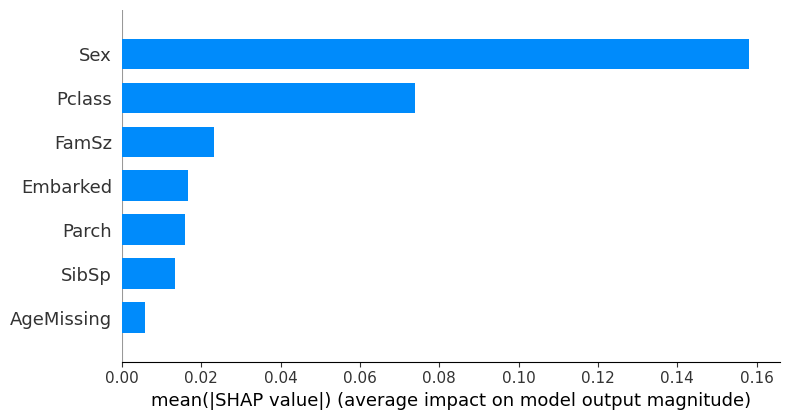

In [168]:
shap.summary_plot(
    shap_values_pos,
    X_shap_sample,
    plot_type="bar",
    show=True
)

#### 2.2 Local Explanations (Per Passenger)

In [184]:
# Select a single passenger to explain
i = 50  # you can change this later
x_instance = X_val.iloc[[i]]
x_instance

,Pclass,Sex,AgeMissing,SibSp,Parch,Embarked,FamSz
759,1,1,1.0,0,0,1,0


In [185]:
# Prediction and probability
pred_class = analysis_model.predict(x_instance)[0]
pred_proba = analysis_model.predict_proba(x_instance)[0, 1]

pred_class, pred_proba

(np.int64(1), np.float64(0.7612596893449447))

In [186]:
# Compute SHAP values for this instance
shap_instance = explainer(x_instance)

# Extract SHAP values for positive class
vals = shap_instance.values
if vals.ndim == 3:
    shap_instance_pos = vals[0, :, 1]
else:
    shap_instance_pos = vals[0]

In [187]:
local_explanation = (
    pd.DataFrame({
        "feature": x_instance.columns,
        "feature_value": x_instance.iloc[0].values,
        "shap_value": shap_instance_pos
    })
    .assign(abs_shap=lambda df: df["shap_value"].abs())
    .sort_values("abs_shap", ascending=False)
)

local_explanation

,feature,feature_value,shap_value,abs_shap
1,Sex,1.0,0.249913,0.249913
0,Pclass,1.0,0.151696,0.151696
5,Embarked,1.0,-0.009564,0.009564
3,SibSp,0.0,-0.007301,0.007301
6,FamSz,0.0,-0.005956,0.005956
4,Parch,0.0,-0.005934,0.005934
2,AgeMissing,1.0,0.004472,0.004472


In [188]:
true_label = y_val.iloc[i]
pred_label = pred_class
pred_proba = pred_proba

true_label, pred_label, pred_proba

print(f"True label: {true_label}")
print(f"Predicted label: {pred_label}")
print(f"Predicted survival probability: {pred_proba:.2f}")

True label: 1
Predicted label: 1
Predicted survival probability: 0.76


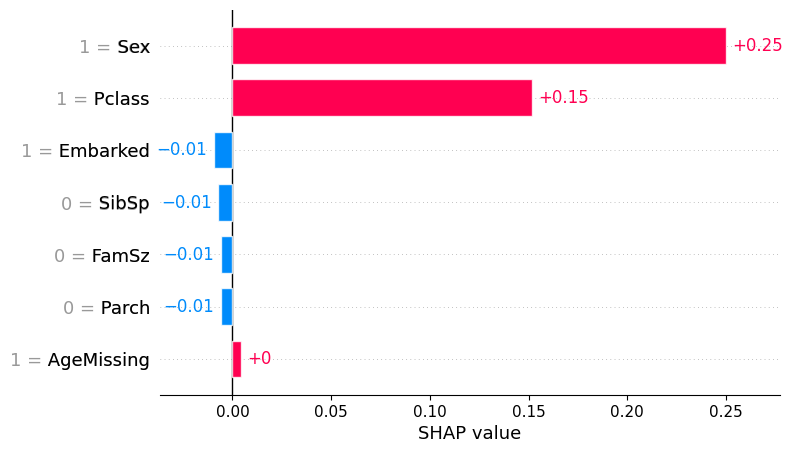

In [189]:
shap.plots.bar(
    shap.Explanation(
        values=shap_instance_pos,
        base_values=shap_instance.base_values[0]
        if hasattr(shap_instance, "base_values") else explainer.expected_value,
        data=x_instance.iloc[0],
        feature_names=x_instance.columns
    ),
    max_display=7
)

#### 2.3 Cohort-Level Behavior & Bias

In [190]:
# Start from SHAP values already computed
shap_df = pd.DataFrame(
    shap_values_pos,
    columns=X_val.columns,
    index=X_val.index
)

# Add cohort variables (from the same rows)
shap_df["Sex"] = X_val["Sex"]
shap_df["Pclass"] = X_val["Pclass"]

In [191]:
mean_abs_shap_by_sex = (
    shap_df
    .drop(columns=["Sex", "Pclass"])
    .abs()
    .groupby(shap_df["Sex"])
    .mean()
    .T
)

mean_abs_shap_by_sex.columns = ["Male (0)", "Female (1)"]
mean_abs_shap_by_sex

,Male (0),Female (1)
AgeMissing,0.005822,0.005643
SibSp,0.015563,0.009466
Parch,0.015696,0.016115
Embarked,0.016521,0.016878
FamSz,0.024172,0.021751


<Axes: title={'center': 'Mean |SHAP| by Sex (Validation Set)'}>

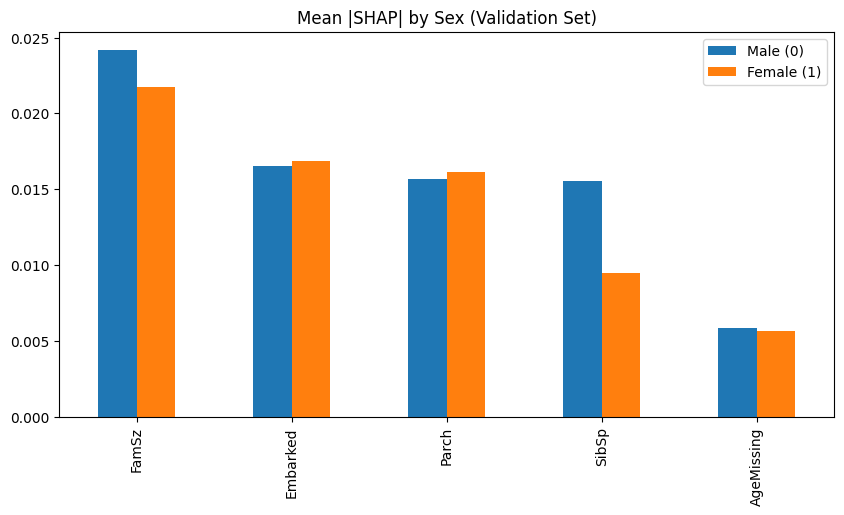

In [192]:
mean_abs_shap_by_sex.sort_values("Female (1)", ascending=False).plot(
    kind="bar",
    figsize=(10, 5),
    title="Mean |SHAP| by Sex (Validation Set)"
)

In [193]:
mean_abs_shap_by_class = (
    shap_df
    .drop(columns=["Sex", "Pclass"])
    .abs()
    .groupby(shap_df["Pclass"])
    .mean()
    .T
)

mean_abs_shap_by_class.columns = ["1st", "2nd", "3rd"]
mean_abs_shap_by_class

,1st,2nd,3rd
AgeMissing,0.004232,0.005923,0.006394
SibSp,0.014802,0.013425,0.012913
Parch,0.019115,0.016415,0.014168
Embarked,0.015107,0.019925,0.016217
FamSz,0.026866,0.020239,0.022820


<Axes: title={'center': 'Mean |SHAP| by Passenger Class (Validation Set)'}>

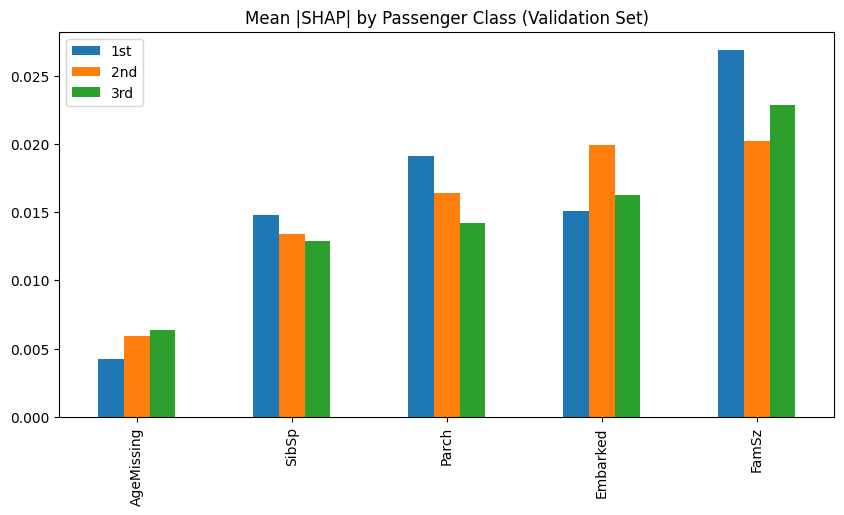

In [194]:
mean_abs_shap_by_class.plot(
    kind="bar",
    figsize=(10, 5),
    title="Mean |SHAP| by Passenger Class (Validation Set)"
)

In [196]:
# Create combined cohort label
shap_df["Sex_Class"] = shap_df["Sex"].astype(str) + "_" + shap_df["Pclass"].astype(str)

# Compute mean |SHAP| by Sex × Class
mean_abs_shap_by_sex_class = (
    shap_df
    .drop(columns=["Sex", "Pclass", "Sex_Class"])  # <-- fix is here
    .abs()
    .groupby(shap_df["Sex_Class"])
    .mean()
    .T
)

mean_abs_shap_by_sex_class

Sex_Class,0_1,0_2,0_3,1_1,1_2,1_3
AgeMissing,0.004687,0.005253,0.006421,0.003321,0.006519,0.006323
SibSp,0.017026,0.017823,0.014451,0.010354,0.009516,0.008958
Parch,0.018990,0.017442,0.013935,0.019364,0.015501,0.014768
Embarked,0.014131,0.022603,0.016165,0.017058,0.017545,0.016353
FamSz,0.027428,0.020298,0.023676,0.025741,0.020187,0.020618


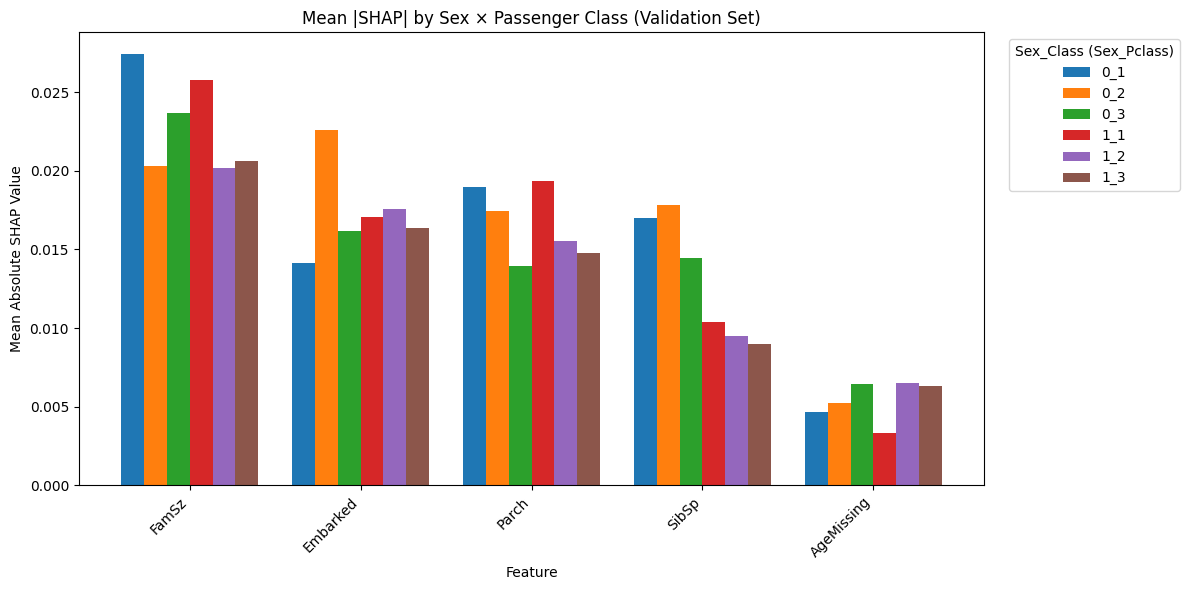

In [197]:
import matplotlib.pyplot as plt

# Sort features by overall importance for readability
ordered_features = (
    mean_abs_shap_by_sex_class
    .mean(axis=1)
    .sort_values(ascending=False)
    .index
)

# Reorder rows
plot_df = mean_abs_shap_by_sex_class.loc[ordered_features]

# Plot
plot_df.plot(
    kind="bar",
    figsize=(12, 6),
    width=0.8
)

plt.title("Mean |SHAP| by Sex × Passenger Class (Validation Set)")
plt.ylabel("Mean Absolute SHAP Value")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.legend(
    title="Sex_Class (Sex_Pclass)",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()

#### 2.4 Counterfactual Analysis (What-Ifs)

In [208]:
mutable_features = ["Pclass", "SibSp", "Parch", "Embarked", "FamSz"]

__i = 52__ is a near miss  
__i = 53__ is not even close; it's a blind spot

In [213]:
i = 53

x_orig = X_val.iloc[[i]].copy()
y_true = y_val.iloc[i]

pred_orig = analysis_model.predict(x_orig)[0]
proba_orig = analysis_model.predict_proba(x_orig)[0, 1]

print("Index:", i)
print("True label (Survived):", y_true)
print("Predicted label:", pred_orig)
print("Predicted P(Survived=1):", round(float(proba_orig), 4))

# quick view of features
x_orig

Index: 53
True label (Survived): 1
Predicted label: 0
Predicted P(Survived=1): 0.1718


,Pclass,Sex,AgeMissing,SibSp,Parch,Embarked,FamSz
17,2,0,0.0,0,0,1,0


In [216]:
counterfactuals = []

for feature in mutable_features:
    orig_val = x_orig.iloc[0][feature]

    # Candidate values (keep modest ranges)
    if feature == "Pclass":
        candidates = [1, 2, 3]
    elif feature == "Embarked":
        candidates = [1, 2, 3]
    elif feature in ["SibSp", "Parch"]:
        candidates = [0, 1, 2, 3, 4]
    elif feature == "FamSz":
        # FamSz is derived; treat cautiously
        candidates = [0, 1, 2, 3, 4, 5]
    else:
        candidates = sorted(pd.Series(X_val[feature].unique()).dropna().tolist())

    for val in candidates:
        if val == orig_val:
            continue

        x_cf = x_orig.copy()
        x_cf.at[x_cf.index[0], feature] = val

        # If you modify SibSp or Parch, keep FamSz consistent (since you engineered it)
        if feature in ["SibSp", "Parch"]:
            x_cf.at[x_cf.index[0], "FamSz"] = (
                x_cf.at[x_cf.index[0], "SibSp"] + x_cf.at[x_cf.index[0], "Parch"]
            )

        # If you modify FamSz directly, DON'T back-compute SibSp/Parch (undefined)
        pred_cf = analysis_model.predict(x_cf)[0]
        proba_cf = analysis_model.predict_proba(x_cf)[0, 1]

        if pred_cf != pred_orig:
            counterfactuals.append({
                "feature": feature,
                "from": orig_val,
                "to": val,
                "orig_pred": int(pred_orig),
                "orig_proba": float(proba_orig),
                "new_pred": int(pred_cf),
                "new_proba": float(proba_cf),
                "delta_proba": float(proba_cf - proba_orig)
            })

cf_df = pd.DataFrame(counterfactuals)

if cf_df.empty:
    print("No one-step counterfactuals found that flip the prediction.")
else:
    cf_df = cf_df.sort_values(
        by="delta_proba", ascending=False
    ).reset_index(drop=True)
    cf_df

No one-step counterfactuals found that flip the prediction.


In [215]:
if len(cf_df) == 0:
    print("No one-step counterfactuals found that flip the prediction.")
else:
    best = cf_df.iloc[0].to_dict()
    print("Best one-step counterfactual:")
    print(best)

    x_best = x_orig.copy()
    x_best.at[x_best.index[0], best["feature"]] = best["to"]

    # keep FamSz consistent if needed
    if best["feature"] in ["SibSp", "Parch"]:
        x_best.at[x_best.index[0], "FamSz"] = (
            x_best.at[x_best.index[0], "SibSp"] + x_best.at[x_best.index[0], "Parch"]
        )

    pred_best = analysis_model.predict(x_best)[0]
    proba_best = analysis_model.predict_proba(x_best)[0, 1]

    display(pd.concat(
        [x_orig.assign(_set="original"), x_best.assign(_set="counterfactual")],
        axis=0
    ).set_index("_set"))

    print("\nOriginal -> Counterfactual")
    print(f"Pred: {pred_orig} -> {pred_best}")
    print(f"P(survival): {proba_orig:.4f} -> {proba_best:.4f}")

Best one-step counterfactual:
{'feature': 'Parch', 'from': 0.0, 'to': 4, 'orig_pred': 1, 'orig_proba': 0.5993107238045079, 'new_pred': 0, 'new_proba': 0.4961586790261657, 'delta_proba': -0.10315204477834217}


,Pclass,Sex,AgeMissing,SibSp,Parch,Embarked,FamSz
_set,,,,,,,
original,2,0,0.0,0,0,1,0
counterfactual,2,0,0.0,0,4,1,4



Original -> Counterfactual
Pred: 0 -> 0
P(survival): 0.1718 -> 0.3214


In [220]:
import pandas as pd
import numpy as np

# Predict on validation set
val_proba = analysis_model.predict_proba(X_val)[:, 1]
val_pred  = (val_proba >= 0.5).astype(int)

val_results = X_val.copy()
val_results["y_true"] = y_val.values
val_results["y_pred"] = val_pred
val_results["p_surv"] = val_proba

# Error flags
val_results["is_fp"] = (val_results["y_true"] == 0) & (val_results["y_pred"] == 1)
val_results["is_fn"] = (val_results["y_true"] == 1) & (val_results["y_pred"] == 0)

val_results.head()

,Pclass,Sex,AgeMissing,SibSp,Parch,Embarked,FamSz,y_true,y_pred,p_surv,is_fp,is_fn
565,3,0,1.0,2,0,1,2,0,0,0.240213,False,False
160,3,0,1.0,0,1,1,1,0,0,0.307618,False,False
553,3,0,1.0,0,0,2,0,1,0,0.229073,False,True
860,3,0,1.0,2,0,1,2,0,0,0.240213,False,False
241,3,1,0.0,1,0,3,1,1,1,0.575606,False,False


In [226]:
# Keep only misclassified observations
errors_only = val_results[val_results["y_true"] != val_results["y_pred"]].copy()

errors_only.shape

(35, 12)

In [227]:
CONF_SURV = 0.80

confident_fp = val_results[val_results["is_fp"] & (val_results["p_surv"] >= CONF_SURV)].copy()
confident_fp.shape

(1, 12)

In [228]:
for t in [0.80, 0.75, 0.70, 0.65]:
    n = ((val_results["is_fp"]) & (val_results["p_surv"] >= t)).sum()
    print(t, n)

0.8 1
0.75 1
0.7 1
0.65 1


In [229]:
feature_cols = ["Pclass", "Sex", "AgeMissing", "SibSp", "Parch", "Embarked", "FamSz"]

confident_fp["signature"] = confident_fp[feature_cols].astype(str).agg("|".join, axis=1)

# Most common confident-FP cohorts
fp_cohorts = (
    confident_fp.groupby("signature")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="count")
)

fp_cohorts.head(10)

,signature,count
0,1|1|1.0|1|2|1|3,1


In [230]:
def decode_signature(sig):
    vals = sig.split("|")
    return dict(zip(feature_cols, vals))

top_sig = fp_cohorts.iloc[0]["signature"]
decode_signature(top_sig), fp_cohorts.iloc[0]["count"]

({'Pclass': '1',
  'Sex': '1',
  'AgeMissing': '1.0',
  'SibSp': '1',
  'Parch': '2',
  'Embarked': '1',
  'FamSz': '3'},
 np.int64(1))

In [231]:
top_cohort = confident_fp[confident_fp["signature"] == top_sig].copy()

top_cohort[feature_cols + ["y_true", "y_pred", "p_surv"]].sort_values("p_surv", ascending=False).head(15)

,Pclass,Sex,AgeMissing,SibSp,Parch,Embarked,FamSz,y_true,y_pred,p_surv
297,1,1,1.0,1,2,1,3,0,1,0.83473


#### 2.5 Explainability Limitations

Explainability tools such as SHAP and counterfactual analysis provide insight into how a trained model arrives at its predictions. However, these tools have important limitations. This section outlines the key constraints and assumptions underlying the explainability results presented in Phase 2.

---

##### 1. Explanations describe model behavior, not real-world causality

SHAP values and counterfactuals explain the **internal reasoning of the model**, not the true causal mechanisms of survival on the Titanic.

- A feature with a large SHAP value does **not** imply it caused survival or death.
- Counterfactuals indicate how predictions would change *within the model*, not what would have happened in reality.

All explanations should therefore be interpreted as **model-conditional**, not causal.

---

##### 2. Explainability reflects biases present in the training data

The model was trained on historical data that reflects:
- social norms and evacuation practices of the time,
- structural inequalities,
- and incomplete or imperfect data collection.

Explainability surfaces these patterns rather than correcting them.  
As a result:
- strong priors (e.g., sex and passenger class) dominate many explanations,
- rare counter-patterns are underrepresented,
- and confident errors can occur for certain cohorts.

This is illustrated by the confident false positives and false negatives identified in Phase 2.

---

##### 3. Local explanations do not generalize

Local explanations (e.g., per-passenger SHAP values and counterfactuals) apply **only to the specific observation being analyzed**.

- Similar passengers may receive different explanations.
- Insights from individual cases should not be generalized without cohort-level analysis.

For this reason, local explanations were complemented with cohort-based SHAP analysis in Step 2.3.

---

##### 4. Counterfactuals depend on feature design and constraints

Counterfactual explanations are sensitive to:
- which features are allowed to change,
- the ranges chosen for those features,
- and how engineered or derived features are handled.

In this project:
- some counterfactuals are internally consistent but not fully realistic,
- others may violate real-world constraints even if they flip the model’s prediction.

Counterfactuals are therefore best interpreted as **diagnostic probes** of the decision boundary, not actionable recommendations.

---

##### 5. High confidence does not imply correctness

Several examples in this analysis demonstrate that:
- the model can be confidently wrong,
- predicted probabilities reflect internal certainty, not correctness,
- explainability can reveal *why* a model is confident, but not *whether it should be*.

This highlights the importance of analyzing errors, not just correct predictions.

---

##### 6. Explainability does not replace model evaluation

Explainability complements but does not substitute for:
- robust evaluation,
- error analysis,
- or fairness assessment.

A model may be interpretable while still exhibiting systematic blind spots or asymmetric failure modes.

---

##### Summary

Explainability tools provide valuable insight into model behavior, decision boundaries, and failure modes. However, they must be interpreted carefully and in context. In this project, explainability was used not to justify model predictions, but to identify blind spots, asymmetric priors, and confidence-related errors. These insights inform the design of interactive diagnostics and user-facing explanations in the next phase.

---